# Calculating band indices with Spyndex packages

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a) 

## Background

Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape. The [Spyndex python package](https://www.nature.com/articles/s41597-023-02096-0) provides access to spectral indices from the Awesome Spectral Indices catalogue. This is a standardized, ready to use, curated list of spectral indices. The Spyndex package currently includes [232 optical and radar indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv). 

One of the benefits of this package is the large number of `optical and radar` indices available for DE Africa sandbox users to easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time, or as inputs to machine learning or classification algorithms using Digital Earth Africa's archive of analysis-ready satellite data.

## Description
This notebook demonstrates how to:
 
* Load Digital Earth Africa's archive of analysis-ready satellite data using `load_ard`
* Calculate NDVI, EVI, GNDVI and kNDVI indices using the `spyndex` function 
* Plot the results for all the indices

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
In addition to the existing packages, the spyndex package will be loaded by importing it. If the cell below returns an error, un-comment the installation line `!pip install spyndex` by removing the `#`.

In [1]:
#!pip install spyndex

In [2]:
# Load the python packages.
%matplotlib inline

import os

os.environ["USE_PYGEOS"] = "0"

import matplotlib.pyplot as plt
import geopandas as gpd

#import spyndex packages
import spyndex

import datacube

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from datacube.utils.geometry import Geometry
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Africa data.

In [3]:
# Connect to the datacube
dc = datacube.Datacube(app="spyndex_function")

### Select location
Using the `define_area` function, select area of interest by specifying `lat`,`lon` and `buffer`. If you have the vector or shapefile uncomment the code below **Method 2** and replace the `aoi.shp` with the path of your  shapefile.

In [4]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=31.23394, lon=31.05560, buffer=0.02)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

### Create a query and load satellite data

To demonstrate how to compute a remote sensing index, we first need to load time series of satellite data for an area. Sentinel-2 satellite data will be used:

It is highly recommended to load data with `load_ard` when calculating indices. This is because `load_ard` performs the necessary data cleaning and scaling for more robust index results. Refer to [Using_load_ard](../Frequently_used_code/Using_load_ard.ipynb) to learn more

In [5]:
# time_range.
time_range = ("2019-06", "2020-06")


# Create a reusable query object.
query = {
    "x": lon_range, 
    "y": lat_range, 
    "time": time_range, 
    "resolution": (-10, 10)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product="s2_l2a", query=query)

# Load available data from Sentinel-2 and filter to retain only times
# with at least 99% good data
ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    min_gooddata=0.99,
    measurements=["red", "green", "blue", "nir"],
    output_crs=output_crs,
    **query
)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 78 out of 158 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 78 time steps


#### Selecting a time slide

In [6]:
ds = ds.isel(time=[4, 11, 15, 23])

#### Print the xarray dataset

In [7]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 4, y: 451, x: 390)
Coordinates:
  * time         (time) datetime64[ns] 2019-06-21T08:51:41 ... 2019-09-11T08:...
  * y            (y) float64 3.459e+06 3.459e+06 ... 3.455e+06 3.455e+06
  * x            (x) float64 3.129e+05 3.129e+05 ... 3.167e+05 3.168e+05
    spatial_ref  int32 32636
Data variables:
    red          (time, y, x) float32 535.0 532.0 535.0 516.0 ... nan nan nan
    green        (time, y, x) float32 589.0 554.0 541.0 530.0 ... nan nan nan
    blue         (time, y, x) float32 354.0 366.0 374.0 324.0 ... nan nan nan
    nir          (time, y, x) float32 1.192e+03 1.15e+03 1.086e+03 ... nan nan
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref


### Plot the images in true colour
The `rgb` function is used to plot the timesteps in our dataset as true colour RGB images:

In [ ]:
rgb(ds, col='time')

### Viewing the attributes for an index 
`spyndex.indices[indexName]` provides the specifications for the index of interest. The cell below prints out the information for the `NDVI`

In [ ]:
print(spyndex.indices["NDVI"])

### Compute the NDVI using the `spectral computeIndex` method.

The cell below shows how spyndex computes the spectral indices using `spectral computeindex` function.
The `spectral computeindex function` takes the 
*  `index` argument and it specifies the spectral indices that is to be calculated
* `params` argument takes the bands from the DE Africa dataset and its corresponding formula name shown in the `print(spyndex.indices["NDVI"])` above. `NDVI` NDVI requires `N` and `R` bands as input which are defined for the DE Africa dataset as `ds.nir` and `ds.red`.

In [ ]:
ds["NDVI"] = spyndex.computeIndex(
    index=["NDVI"], 
    params={
        "N": ds.nir, 
        "R": ds.red
    }
)

### Calculate Enhanced Vegetation Index (EVI) using spyndex

Using `spyndex.indices[indexName]` gives the details of the Spectral Index being used.
The cell below prints information concerning the `EVI` Spectral Index.

In [ ]:
print(spyndex.indices["EVI"])

### Compute the EVI index using the `spectral computeIndex` method.

The `EVI` has constant values for its computation, as we can see in the formula above. 


The Spyndex package provides default constant values which can also be overwritten. The [constants](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/constants.json) can be accessed using `spyndex.constants` as shown below.

In [ ]:
ds["EVI"] = spyndex.computeIndex(
    index=["EVI"],
    params={
        "C1": spyndex.constants["C1"].value,
        "C2": spyndex.constants["C2"].value,
        "g": spyndex.constants["g"].value,
        "L": spyndex.constants["L"].value,
        "N": ds.nir,
        "R": ds.red,
        "B": ds.blue,
    },
)

### Normalisation

The `calculate_indices` function from `deafrica_tools` normalises Sentinel-2 values according to a maximum surface reflectance value of `10,000`. We can adapt the Spyndex calculation, as below, to match this normalisation procedure.

In [ ]:
ds["EVI"] = spyndex.computeIndex(
    index=["EVI"],
    params={
        "C1": spyndex.constants["C1"].value,
        "C2": spyndex.constants["C2"].value,
        "g": spyndex.constants["g"].value,
        "L": spyndex.constants["L"].value,
        "N": ds.nir/10000,
        "R": ds.red/10000,
        "B": ds.blue/10000,
    },
)

#### Green Normalized Difference Vegetation Index (GNDVI)

The Green Normalized Difference Vegetation Index [GNDVI](https://pro.arcgis.com/en/pro-app/latest/arcpy/image-analyst/gnvdi.htm#:~:text=The%20Green%20Normalized%20Difference%20Vegetation%20Index%20(GNDVI)%20method%20is%20a,uptake%20into%20the%20plant%20canopy.) is a vegetation index for estimating photosynthetic activity and is a commonly used to determine water and nitrogen uptake into the plant canopy.
GNDVI is more sensitive to chlorophyll variation in the crop and has a higher saturation point than NDVI. It can be used in crops with dense canopies or in more advanced stages of development. More information can be found in the Reference in the cell below.

#### Viewing the attributes of the GNDVI

In [ ]:
print(spyndex.indices["GNDVI"])

#### Calculate GNDVI using spyndex

In [ ]:
ds["GNDVI"] = spyndex.computeIndex(
    index=["GNDVI"], 
    params={
        "N": ds.nir, 
        "G": ds.green
    }
)

### Kernel Normalized Difference Vegetation Index (kNDVI)

The NDVI can only capture linear relationships of the near infrared (NIR) - red difference and a parameter of interest, such as green biomass. In reality, this relationship is nonlinear. [Kernel NDVI (kNDVI) was developed](https://www.science.org/doi/10.1126/sciadv.abc7447) to account for higher-order relations between the spectral channels with a nonlinear generalization of the commonly used Normalized Difference Vegetation Index (NDVI). kNDVI has been shown to produce more accurate estimates of key physical variables such as gross primary productivity.

In [ ]:
print(spyndex.indices["kNDVI"])

In [ ]:
# Use the computeKernel() method to compute the required kernel for kernel indices like the kNDVI
# Kernel Normalized Difference Vegetation Index
parameters = {
    "kNN": 1.0,
    "kNR": spyndex.computeKernel(
        kernel="RBF",
        params={"a": ds.nir , "b": ds.red, "sigma": 0.5 * (ds.nir + ds.red)},
    ),
}
ds["kNDVI"] = spyndex.computeIndex("kNDVI", parameters)

### Plot the results of NDVI, EVI, GNDVI, KNDVI

The plot below enables comparison of NDVI, EVI, GNDVI, and kNDVI. Can you observe any differences between the indices? For example, there appears to be more saturation (greater frequency of higher/greener values) for NDVI and GNDVI in the July timestep compared with EVI and kNDVI.

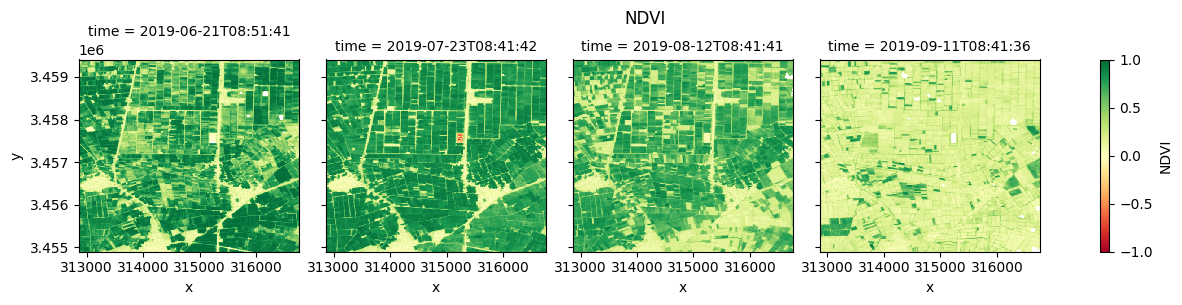

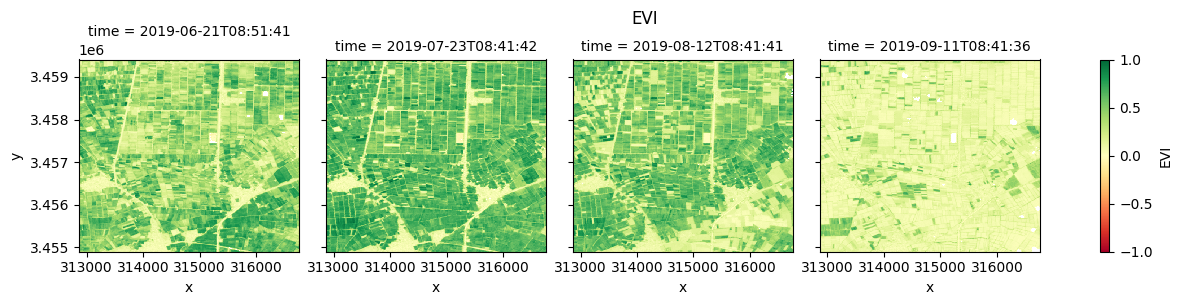

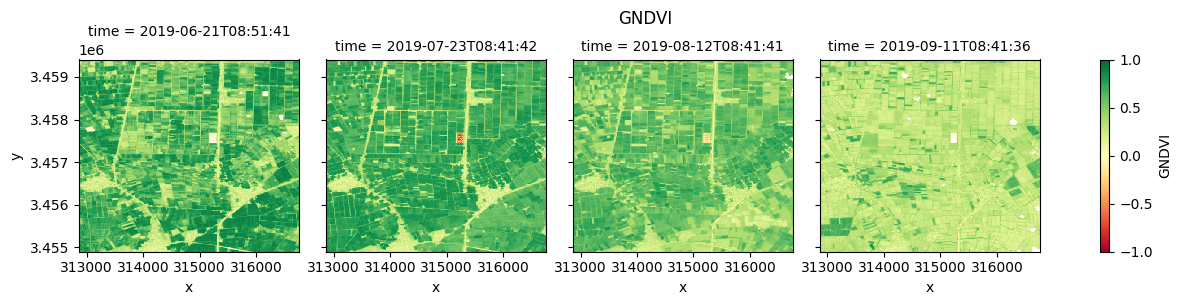

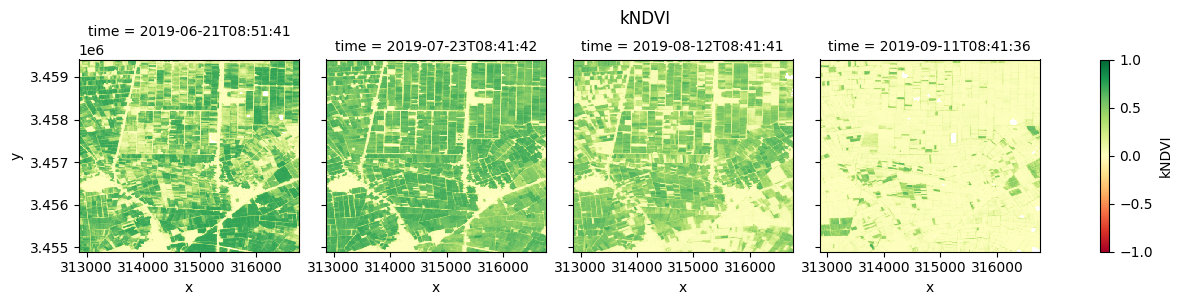

In [18]:
#NDVI
fig_ndvi = ds.NDVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1)
fig_ndvi.fig.suptitle("NDVI", y= 1.0)
#EVI
fig_evi = ds.EVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1)
fig_evi.fig.suptitle("EVI", y= 1.0);
#GNDVI
fig_gndvi = ds.GNDVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1)
fig_gndvi.fig.suptitle("GNDVI", y= 1.0)
#kNDVI
fig_kndvi = ds.kNDVI.clip(-1,1).plot(col="time", cmap="RdYlGn", vmin=-1, vmax=1)
fig_kndvi.fig.suptitle("kNDVI", y= 1.0)
plt.show()

## Conclusion

This notebook demonstrates how the `Spyndex package` can be used with DE Africa datasets to compute Spectral Indices. There are [232 optical and radar](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv) indices available through the package, try it out and modify the notebook to test different indices and their results.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [19]:
print(datacube.__version__)

1.8.13


**Last Tested:**

In [20]:
from datetime import date
print(date.today())

2023-06-29
